In [1]:
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
from spacy import displacy
from collections import Counter

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
# TODO: Replace with your Student Number
_STUDENT_NUM = 'A0251445J'

In [3]:
def lemmetize_all(X):
    """ TODO: preprocess data"""
    X_lemmetize = []
    wnl = WordNetLemmatizer()
    for sentence in X:
        tmp = []
        for word, tag in nltk.pos_tag(word_tokenize(sentence)):
            if tag.startswith('NN'):
                tmp.append(wnl.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                tmp.append(wnl.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                tmp.append(wnl.lemmatize(word, pos='a'))
            elif tag.startswith('R'):
                tmp.append(wnl.lemmatize(word, pos='r'))
            else:
                tmp.append(word)
            
        X_lemmetize.append(' '.join(tmp))
        
    return X_lemmetize

In [4]:
def add_sentence_length(X):
    return np.array([len(sentence.split()) for sentence in X]).reshape((-1, 1))

In [5]:
def add_polarity(X):
    sid = SentimentIntensityAnalyzer()
    polarity = []
    for sentence in X:
        ss = sid.polarity_scores(sentence)
        polarity.append(list(ss.values()))
    
    return np.array(polarity)

In [6]:
def add_num_count(X):
    num_count = []
    for sentence in X:
        count = 0
        for _, tag in nltk.pos_tag(nltk.word_tokenize(sentence)):
            if tag == 'CD':
                count += 1
        num_count.append(count)

    return np.array(num_count).reshape(-1, 1)

In [18]:
def extract_named_entities_by_types(X_train, X_test):
    count = []
    nlp = spacy.load('en_core_web_sm')
    for sentence in X_train:
        labels = [x.label_ for x in nlp(sentence).ents]
        count.append(Counter(labels))
    for sentence in X_test:
        labels = [x.label_ for x in nlp(sentence).ents]
        count.append(Counter(labels))

    return pd.DataFrame(count).fillna(0)

In [ ]:
def train_model(model, X_train, y_train, method = 'nn', need_dev = 'False'):
    """ TODO: train your model based on the training data """
        
    if method == 'nn':
        model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        
        if need_dev == 'True':
            X_train_post, X_dev_post, y_train_post, y_dev_post = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42)
            history = model.fit(
                X_train_post, 
                y_train_post,
                batch_size=512,
                epochs=15,
                validation_data=(X_dev_post, y_dev_post),
            )
        else:
            history = model.fit(
                X_train, 
                y_train,
                batch_size=512,
                epochs=15,
            )
    
    return

In [8]:
def predict(model, X_test, method = 'nn'):
    """ TODO: make your prediction here """
    if method == 'nn':
        y_pred = np.argmax(model.predict(X_test), axis=1) - 1
    return y_pred

In [9]:
def generate_result(test, y_pred, filename):
    """ generate csv file base on the y_pred """
    test['Verdict'] = pd.Series(y_pred)
    test.drop(columns=['Text'], inplace=True)
    test.to_csv(filename, index=False)

In [ ]:
def main():
    """ load train, val, and test data """
    train = pd.read_csv('train.csv')
    X_train = train['Text']
    y_train = train['Verdict']
    
    test = pd.read_csv('test.csv')
    X_test = test['Text']
    # preprocessing
    
    
    model = None  # TODO: Define your model here
    
    model = keras.Sequential(
    [
        layers.Dense(32, activation='relu', input_shape=(X_train_vec.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax'),
    ])

    # model.summary()
    
    train_model(model, X_train, y_train)
    
#     # test your model
#     y_pred = predict(model, X_train)

    # Use f1-macro as the metric
    score = f1_score(y_train, y_pred, average='macro')
    print('score on validation = {}'.format(score))

    # generate prediction on test data
    y_pred = predict(model, X_test)
    
#     generate_result(test, y_pred, _STUDENT_NUM + ".csv")

In [ ]:
# Allow the main class to be invoked if run as a file.
if __name__ == "__main__":
    main()


In [41]:
train = pd.read_csv('train.csv')
X_train = train['Text']
y_train = train['Verdict']

test = pd.read_csv('test.csv')
X_test = test['Text']

In [12]:
# X_train = lemmetize_all(X_train)

In [79]:
vectorizer = TfidfVectorizer(max_features=500).fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()

y_train_dum = pd.get_dummies(y_train)

In [80]:
X_train_vec.shape

(22501, 500)

In [81]:
# Additional features
scaler = MinMaxScaler()
X_train_vec = np.concatenate((X_train_vec, scaler.fit_transform(add_sentence_length(X_train))), axis=1)

In [82]:
polarity = add_polarity(X_train)
X_train_vec = np.concatenate((X_train_vec, polarity), axis=1)

In [83]:
num_count = add_num_count(X_train)
X_train_vec = np.concatenate((X_train_vec, num_count), axis=1)

In [19]:
data = extract_named_entities_by_types(X_train, X_test)

In [22]:
data[:len(X_train_vec)]

,PERSON,NORP,GPE,ORG,DATE,FAC,CARDINAL,PERCENT,ORDINAL,MONEY,TIME,LOC,WORK_OF_ART,LAW,EVENT,PRODUCT,QUANTITY,LANGUAGE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22497,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22498,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22499,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X_train_vec = np.concatenate((X_train_vec, data[:len(X_train_vec)]), axis=1)

In [86]:
X_train_vec.shape

(22501, 524)

In [87]:
reg = keras.regularizers.l2(0.001)
tf.random.set_seed(0)

model = keras.Sequential(
    [
        layers.Dense(32, activation='relu', input_shape=(X_train_vec.shape[1],), kernel_regularizer=reg),
        # layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=reg),
        layers.Dense(6, activation='sigmoid', kernel_regularizer=reg),
        # layers.Dropout(0.3, seed=1),
        layers.Dense(3, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 32)                16800     
                                                                 
 dense_64 (Dense)            (None, 16)                528       
                                                                 
 dense_65 (Dense)            (None, 6)                 102       
                                                                 
 dense_66 (Dense)            (None, 3)                 21        
                                                                 
Total params: 17,451
Trainable params: 17,451
Non-trainable params: 0
_________________________________________________________________


In [88]:
X_train_post, X_dev_post, y_train_post, y_dev_post = train_test_split(
                X_train_vec, y_train_dum, test_size=0.1, random_state=42)
history = model.fit(
    X_train_post, 
    y_train_post,
    batch_size=512,
    epochs=50,
    validation_data=(X_dev_post, y_dev_post),
)

Epoch 1/50
40/40 [==============================] - 1s 7ms/step - loss: 1.4508 - accuracy: 0.1063 - val_loss: 1.3283 - val_accuracy: 0.1111
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 1.2234 - accuracy: 0.1214 - val_loss: 1.1119 - val_accuracy: 0.2821
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 1.0337 - accuracy: 0.6413 - val_loss: 0.9773 - val_accuracy: 0.6801
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 0.9334 - accuracy: 0.7048 - val_loss: 0.9109 - val_accuracy: 0.7015
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 0.8802 - accuracy: 0.7146 - val_loss: 0.8721 - val_accuracy: 0.7037
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 0.8476 - accuracy: 0.7186 - val_loss: 0.8456 - val_accuracy: 0.7095
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 0.8246 - accuracy: 0.7230 - val_loss: 0.8270 - val_accuracy: 0.7148
Epoch 8/50
40/40 [==

In [40]:
history = model.fit(
    X_train_vec, 
    y_train_dum,
    batch_size=512,
    epochs=25,
)

Epoch 1/25
44/44 [==============================] - 1s 12ms/step - loss: 0.9813 - accuracy: 0.6817
Epoch 2/25
44/44 [==============================] - 0s 10ms/step - loss: 0.7264 - accuracy: 0.7359
Epoch 3/25
44/44 [==============================] - 0s 9ms/step - loss: 0.6523 - accuracy: 0.7617
Epoch 4/25
44/44 [==============================] - 0s 8ms/step - loss: 0.6169 - accuracy: 0.7759
Epoch 5/25
44/44 [==============================] - 0s 9ms/step - loss: 0.5950 - accuracy: 0.7875
Epoch 6/25
44/44 [==============================] - 0s 8ms/step - loss: 0.5798 - accuracy: 0.7966
Epoch 7/25
44/44 [==============================] - 0s 9ms/step - loss: 0.5665 - accuracy: 0.8036
Epoch 8/25
44/44 [==============================] - 0s 9ms/step - loss: 0.5566 - accuracy: 0.8118
Epoch 9/25
44/44 [==============================] - 0s 9ms/step - loss: 0.5500 - accuracy: 0.8143
Epoch 10/25
44/44 [==============================] - 0s 9ms/step - loss: 0.5414 - accuracy: 0.8193
Epoch 11/25
44/44

In [27]:

# X_test = lemmetize_all(X_test)
X_test_vec = vectorizer.transform(X_test).toarray()
X_test_vec = np.concatenate((X_test_vec, scaler.transform(add_sentence_length(X_test))), axis=1)

polarity = add_polarity(X_test)
X_test_vec = np.concatenate((X_test_vec, polarity), axis=1)

num_count = add_num_count(X_test)
X_test_vec = np.concatenate((X_test_vec, num_count), axis=1)

X_test_vec = np.concatenate((X_test_vec, data[len(X_train_vec):]), axis=1)

In [42]:
model.predict(X_test_vec)

33/33 [==============================] - 0s 863us/step


array([[0.49636358, 0.48105693, 0.02257948],
       [0.02577839, 0.00897695, 0.96524465],
       [0.69203895, 0.11476183, 0.19319928],
       ...,
       [0.99529403, 0.00355991, 0.00114604],
       [0.73742473, 0.14536324, 0.11721209],
       [0.9526122 , 0.02674699, 0.0206408 ]], dtype=float32)

In [43]:
y_pred = np.argmax(model.predict(X_test_vec), axis=1) - 1

33/33 [==============================] - 0s 676us/step


In [44]:
generate_result(test, y_pred, _STUDENT_NUM + ".csv")

In [223]:
# y_pred = model.predict(X_train_vec)
y_pred = np.argmax(model.predict(X_train_vec), axis=1) - 1

704/704 [==============================] - 1s 826us/step


In [224]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.88      0.95      0.91     14685
           0       0.77      0.48      0.59      2403
           1       0.81      0.78      0.80      5413

    accuracy                           0.86     22501
   macro avg       0.82      0.74      0.77     22501
weighted avg       0.85      0.86      0.85     22501



<Axes: >

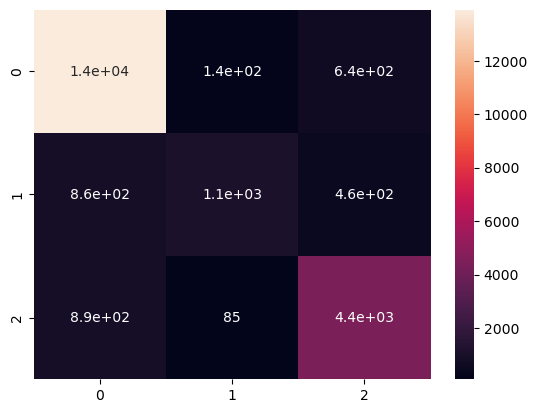

In [130]:
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True)

In [131]:
confusion_matrix(y_train, y_pred)

array([[13910,   140,   635],
       [  856,  1091,   456],
       [  893,    85,  4435]], dtype=int64)

In [ ]:
vectorizer = CountVectorizer()
vectorized_texts = vectorizer.fit_transform(X_train)

In [ ]:
vectorized_texts

<22501x11424 sparse matrix of type '<class 'numpy.int64'>'
	with 335979 stored elements in Compressed Sparse Row format>

In [ ]:
classifier = MultinomialNB()
classifier.fit(vectorized_texts, y_train)

MultinomialNB()

In [ ]:
y_pred = classifier.predict(vectorized_texts)

In [ ]:
score = f1_score(y_train, y_pred, average='macro')

In [ ]:
score

0.7175508264672326

In [ ]:
y_pred = classifier.predict(vectorizer.transform(X_test))

In [178]:
class_polarity = collections.defaultdict(list)
class_polarity[-1] = [0, 0, 0, 0]
class_polarity[0] = [0, 0, 0, 0]
class_polarity[1] = [0, 0, 0, 0]

sid = SentimentIntensityAnalyzer()

for i in range(len(X_train)):
    ss = sid.polarity_scores(X_train[i])
    class_polarity[y_train[i]][0] += ss['neg']
    class_polarity[y_train[i]][1] += ss['neu']
    class_polarity[y_train[i]][2] += ss['pos']
    class_polarity[y_train[i]][3] += ss['compound']

<AxesSubplot:>

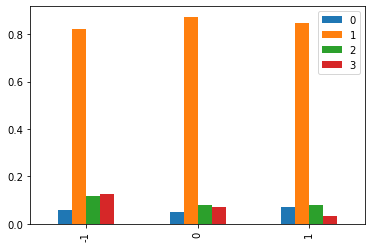

In [197]:
pd.DataFrame.from_dict(class_polarity, orient='index').div(y_train.value_counts(), axis=0).plot.bar()

In [136]:
nltk.pos_tag(nltk.word_tokenize("Storwerqw"))

[('Storwerqw', 'NN')]

In [104]:
lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [105]:
X_train_vec.shape

(22501, 5006)

In [ ]:
lr_clf.fit(X_train_vec, y_train)

In [107]:
y_pred = lr_clf.predict(X_train_vec)

In [113]:
f1_score(y_train, y_pred, average='macro')

0.7048283674184939

In [177]:
data.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22501 entries, 0 to 22500
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PERSON       22501 non-null  float64
 1   NORP         22501 non-null  float64
 2   GPE          22501 non-null  float64
 3   ORG          22501 non-null  float64
 4   DATE         22501 non-null  float64
 5   FAC          22501 non-null  float64
 6   CARDINAL     22501 non-null  float64
 7   PERCENT      22501 non-null  float64
 8   ORDINAL      22501 non-null  float64
 9   MONEY        22501 non-null  float64
 10  TIME         22501 non-null  float64
 11  LOC          22501 non-null  float64
 12  WORK_OF_ART  22501 non-null  float64
 13  LAW          22501 non-null  float64
 14  EVENT        22501 non-null  float64
 15  PRODUCT      22501 non-null  float64
 16  QUANTITY     22501 non-null  float64
 17  LANGUAGE     22501 non-null  float64
dtypes: float64(18)
memory usage: 3.1 MB


In [165]:
doc = nlp('European authorities fined Jackson Mike a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices 14 people. Please call Tom here')
labels = [x.label_ for x in doc.ents]
list1.append(Counter(labels))

In [166]:
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Jackson Mike', 'ORG'), ('a record $5.1 billion', 'MONEY'), ('Wednesday', 'DATE'), ('14', 'CARDINAL'), ('Tom', 'PERSON')]


,NORP,ORG,MONEY,DATE,CARDINAL,PERSON
0,1,1,1,1,1,NaN
1,1,1,1,1,1,NaN
2,1,1,1,1,1,NaN
3,1,1,1,1,1,NaN
4,1,1,1,1,1,NaN
5,1,1,1,1,1,1.0
